In [120]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from google.cloud import bigquery

## Note # Real system , you need to get data from PostGrest # if no incident  it will be 0
## Schcule to send summary case at 00:01 and get count yester day to predict begining of the comming week

In [121]:
dateTimeCol='open_datetime'
dateCol='incident_date'

countCol='count_incident'

imported_from='2000-01-01'

tf='W-SUN'
tf='D'

In [122]:
# df_incident = pd.read_csv('data/Incident.csv',parse_dates=[dateTimeCol])
# change column name  open_datetime to incident_date

sql=f"""
SELECT  id,open_datetime as {dateCol}, updated_at,imported_at
FROM `pongthorn.SMartDW.incident` WHERE imported_at >= '{imported_from}'
order by imported_at
"""

client_bq = bigquery.Client()
query_result=client_bq.query(sql)
df_incident=query_result.to_dataframe()

df_incident=df_incident.drop_duplicates(subset=['id'],keep='first')




print(df_incident.info())
df_incident.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 0 to 2348
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             2344 non-null   Int64         
 1   incident_date  2344 non-null   datetime64[ns]
 2   updated_at     2344 non-null   datetime64[ns]
 3   imported_at    2344 non-null   datetime64[ns]
dtypes: Int64(1), datetime64[ns](3)
memory usage: 93.9 KB
None


,id,incident_date,updated_at,imported_at
2344,2507,2023-03-21 14:25:00,2023-03-21 18:17:19,2023-03-21 18:29:01.995333
2345,2480,2023-01-26 08:22:00,2023-03-21 11:12:53,2023-03-21 18:29:01.995333
2346,2488,2023-01-26 13:08:00,2023-03-21 11:35:30,2023-03-21 18:29:01.995333
2347,2486,2023-01-26 09:49:00,2023-03-21 11:21:34,2023-03-21 18:29:01.995333
2348,2487,2023-01-26 11:34:00,2023-03-21 11:28:41,2023-03-21 18:29:01.995333


# Create Index

In [123]:
df_incident[dateCol]=df_incident[dateCol].dt.strftime('%Y-%m-%d')
df_incident[dateCol]=pd.to_datetime(df_incident[dateCol], format='%Y-%m-%d')
df_incident=df_incident[[dateCol,'id']]

In [124]:
dfCountIncident=df_incident.groupby([dateCol])[['id']].agg('count').reset_index()
dfCountIncident.columns=['incident_date',countCol]
dfCountIncident.info()
dfCountIncident.tail(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523 entries, 0 to 522
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   incident_date   523 non-null    datetime64[ns]
 1   count_incident  523 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.3 KB


,incident_date,count_incident
513,2023-03-09,4
514,2023-03-10,13
515,2023-03-13,3
516,2023-03-14,8
517,2023-03-15,7
518,2023-03-16,7
519,2023-03-17,5
520,2023-03-19,1
521,2023-03-20,4
522,2023-03-21,2


In [125]:
period_index=pd.date_range(start=from_date,end=to_date, freq='D')
# print(period_index)

dfDate=pd.DataFrame(index=period_index,columns=['date'])
dfDate.reset_index(drop=False,inplace=True)
dfDate['date']=dfDate['index']
dfDate.drop(columns=['index'],inplace=True)
print(dfDate.info())
dfDate.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    810 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 6.5 KB
None


,date
805,2023-03-17
806,2023-03-18
807,2023-03-19
808,2023-03-20
809,2023-03-21


In [126]:
df=dfDate.merge(dfCountIncident,how='left',left_on='date',right_on='incident_date')
df=df[['date',countCol]]
df.fillna(value=0,inplace=True)
df=df.set_index('date')
print(df.info())
df.tail(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 810 entries, 2021-01-01 to 2023-03-21
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   count_incident  810 non-null    float64
dtypes: float64(1)
memory usage: 12.7 KB
None


,count_incident
date,
2023-03-12,0.0
2023-03-13,3.0
2023-03-14,8.0
2023-03-15,7.0
2023-03-16,7.0
2023-03-17,5.0
2023-03-18,0.0
2023-03-19,1.0
2023-03-20,4.0


In [127]:
dfXYZ=df.resample(tf).sum()
print(dfXYZ.info())
dfXYZ.tail(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 810 entries, 2021-01-01 to 2023-03-21
Freq: D
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   count_incident  810 non-null    float64
dtypes: float64(1)
memory usage: 12.7 KB
None


,count_incident
date,
2023-03-12,0.0
2023-03-13,3.0
2023-03-14,8.0
2023-03-15,7.0
2023-03-16,7.0
2023-03-17,5.0
2023-03-18,0.0
2023-03-19,1.0
2023-03-20,4.0


In [132]:
dfXYZ.to_csv('NoIncident.csv',index=True)

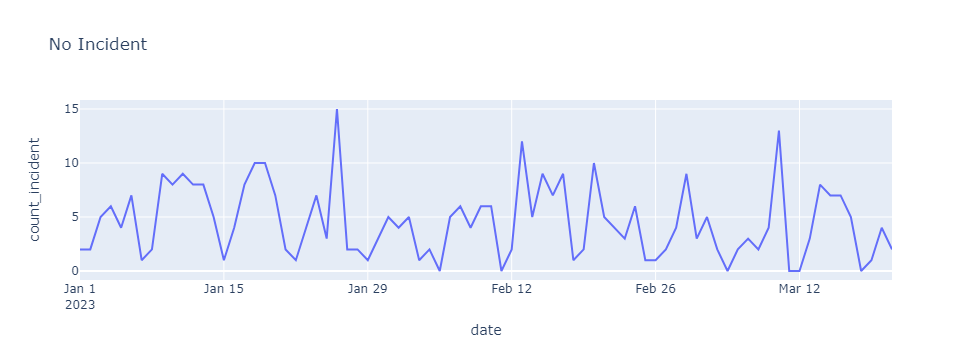

In [134]:
import plotly.express as px
# fig = px.line(df.query("date>='2022-01-01'"), x="date", y='count_daily_incident', title='Daily Incident')
fig = px.line(dfXYZ.loc["2023-01-01":,],y=countCol, title='No Incident')
fig.show()